# Introduction

In today's world where thousands of songs are released everyday, the competition to become successful is stiff and a lot of factors become important when we try to understand the combination of features that make a song popular.  
Through this project, we aim to predict a song's popularity, and the criteria for a song to be called popular is whether it has ever occurred on the billboard charts. In this particular case, we have targeted pop songs and their presence on the billboard. 

## Data Science Pipeline

<H3><a href="#Data Collection" style="color:Black">Step 1 : Data Collection</a></H3>  
The data collection phase was divided into three parts:  

1. Extracting song features using Spotify API. 
2. Scraping the lyrics for the songs using musixmatch.com and lyrics.wikia.com 
3. Collecting the response variable (BillBoard presence) using the BillBoard API    

<H3><a href="#Data Exploration / Visualization" style="color:Black">Step 2 : Data Exploration / Visualization</a></H3>  
In the data exploration phase, we generated various visual representations in the data to understand interactions between features. Our aim was to understand the features which had the most impact on the likeliness of the song ending up on the BillBoard.

<H3><a href="#Data Processing" style="color:Black">Step 3 : Data Processing</a></H3>  
We spent most of our time in engineering lyrical features as we felt that song lyrics play a major impact on how much a song gets appreciated by the audience.  

+ We created an alliteration algorithm for extracting interleaved alliteration patterns present in the songs. For example, we extracted the first stress syllable present in each word and calculated alliteration counts with a skip length of 3 . More details of the algorithm are explained further in the project.

+ For gaining more textual context from the lyrical features, we measured degrees of various emotions like Anger, fear, joy etc. We then extracted the Psycholinguistic features such as Sentiment Score, Imagery and meaningfulness. To understand the dominant parts of speech present in the lyrics, we derived features like Count of nouns and verbs etc.  

+ Another set of important features that we extracted from the lyrics were using n-grams. Using n-grams, we computed the largest n-gram present in the song lyrics and also recorded the length of the most repeating n-gram in the lyrics.  

Combining the three features into our model provided us with a strong set of lyrical features we could use to proceed further with our analysis.

<H3><a href="#Analysis" style="color:Black">Step 4 : Analysis</a></H3>  
We fitted multiple models during our analysis and decided to move forward with Support Vector Machine as it allowed us to have a good recall of 83.5% while keeping the model interpretable. The insights we derived from our analysis were as follows. For a song to be popular: 
1. Lyrics play an important role in making the song popular, and a few audio features like danceability, loudness and tempo have an effect on the popularity.
2. Specifically, popular songs consist of large number of short repetitve phrases. (Large number of short n-grams), and
3. Moderate energy and tempo feature.

Another interesting insight we derived was that on an average, 40% portion of the pop song lyrics were alliterations.

## Data Collection <a id='Data Collection'></a>

In [2]:
import string
import time
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

#### Song Data extraction using Spotify API

In [ ]:
def get_song_features(song_ids,token):
    """Takes song ids extracted from the search API and returns its audio features like key,danceability and 10 others. 

    Args:
        song_ids (string): song_ids for which you want to extract music features
        token (string): access token for the API (this works only for 1 hour)

    Returns:
        audio features (pd.Dataframe):  returns a datafram containing songid and its 12 musical features.
    """ 
    url="https://api.spotify.com/v1/audio-features?ids="+song_ids
    r = requests.get(url, headers = {"Authorization":"Bearer " + token})
    body=dict(json.loads(r.content))
    audio_features=pd.DataFrame(body['audio_features'])
    return audio_features

In [ ]:
i=0
final_df=pd.DataFrame()
all_pops=['pop']

for pop_type in all_pops:
    flag=True
    offset=0
    #column names for the Dataframe that we are extracting from the Spotify API.
    df = pd.DataFrame(columns=['genre','id','name','popularity','duration_ms','number_of_artists'
                               ,'artists','number_of_available_markets','available_markets','explicit'
                               ,'disc_number','preview_url','href','album_id','album_name','album_type'
                               ,'album_release_date','album_release_date_precision','number_of_album_artists'
                               ,'album_artists','number_of_album_available_markets','album_available_markets','album_uri'])
    while(flag):
        song_ids=[]
        url="https://api.spotify.com/v1/search?q=genre%3A"+pop_type+"%20year%3A2016&type=track&market=US&limit=50&offset="+str(offset)
        token=<YOUR API TOKEN>
        r = requests.get(url, headers = {"Authorization":"Bearer " + token})
        body=dict(json.loads(r.content))
        if 'tracks' in body.keys():
            if len(body["tracks"]["items"])!=0:
                for row in body["tracks"]["items"]:
                    artists=''
                    for artist in row['artists']:
                        artists+=(artist['name']+',')

                    artists=artists.strip(',')
                    album_artists=''
                    for album_artist in row['album']['artists']:
                        album_artists+=(album_artist['name']+',')
                    album_artists=album_artists.strip(',')
                    album_available_markets=','.join(row['album']['available_markets'])

                    df.loc[i]=[pop_type.replace("%20",' '),row['id'],row['name'],row['popularity']
                               ,row['duration_ms'],len(row['artists']),artists,len(row['available_markets'])
                               ,','.join(row['available_markets']),row['explicit'],row['disc_number']
                               ,row['preview_url'],row['href'],row['album']['id'],row['album']['name']
                               ,row['album']['album_type'],row['album']['release_date']
                               ,row['album']['release_date_precision'],len(album_artists)
                               ,album_artists,len(album_available_markets),album_available_markets
                               ,row['album']['uri']]
                    song_ids.append(row['id'])
                    i+=1

                song_ids=','.join(song_ids)
                features_df=get_song_features(song_ids,token)
                final_df=final_df.append(pd.merge(df, features_df, on='id'))

            else:
                flag=False
            offset+=50
            print(offset)

final_df.reset_index(inplace=True,drop=True)
final_df.to_csv('DestinationFolder\Filename.csv')

#### BillBoard Song List extraction using Billboard API

In [ ]:
date_start = date(2016, 1, 2) #takes saturdays
date_end = date(2017, 7, 1)
songs=[]
while True:
    if date_end > date_start:
        date_start = date_start+timedelta(days=7)
        rolling_date = date_start.strftime("%Y-%m-%d")
        s = "http://billboard.modulo.site/charts/"+rolling_date
        time.sleep(5)
        json_string = requests.get(s,headers={'User-Agent': 'Mozilla/5.0'})

        songs.extend(json_string.json()['songs'])
        dates.append(rolling_date)

In [6]:
songs_data = open('songs.csv', 'w', newline='')
# create the csv writer object
csvwriter = csv.writer(songs_data)
count = 0

for song in songs:
    if count == 0:
        header = song.keys()
        csvwriter.writerow(header)
        count += 1
    csvwriter.writerow(song.values())

songs_data.close()

#### Lyrics Scraper from lyrics.wikia.com 

In [ ]:
song_df = pd.read_csv("song&bill.csv",encoding='latin-1')
temp_df = song_df
song_df = song_df
artists = list(song_df["artists"])
songs = list(song_df["name"])
artists_mod = []
for each_arist in artists:
    each_arist = each_arist.replace("&","")
    each_arist = each_arist.replace(".","")
    each_arist = each_arist.replace("$","")
    each_arist = re.sub(",.*","",each_arist)
    each_arist = each_arist.replace(" ","_")
    artists_mod.append(each_arist)
songs_mod = []
for each_song in songs:
    each_song = re.sub("..feat.*","",each_song)
    each_song = each_song.replace(".","")
    each_song = each_song.replace("&","")
    each_song = each_song.replace("$","")
    each_song = each_song.replace("-","")
    each_song = each_song.replace("\"","")
    each_song = re.sub("\s+","_",each_song)
    songs_mod.append(each_song)
source_codes = []
response_codes = {}
lyrics = []
count = 0
for i in range(0,len(songs_mod)):
    count+=1
    if count>20:
        time.sleep(2)
        count = 0
    response = requests.get("http://lyrics.wikia.com/wiki/"+artists_mod[i]+":"+songs_mod[i])
    if response.status_code in response_codes:
        response_codes[response.status_code]+=1
    else:
        response_codes[response.status_code]=1
    soup = BeautifulSoup(response.text,"html.parser")
    if soup.find("div",{"class":"lyricbox"}):
        link = soup.find("div",{"class":"lyricbox"})
        link = str(link).replace("<br/><br/>",". \n")
        link = link.replace("<br/>",". ")
        link = link.replace("<div class=\"lyricbox\">","")
        link = link.replace("<div class=\"lyricsbreak\"></div>\n</div>","")
        lyrics.append(link)
    else:
        lyrics.append(None)
song_df["lyrics"] = pd.Series(lyrics)
song_df.to_csv('AllPopOutTest.csv', sep=',')

#### Lyrics Scraper from musixmatch.com 

In [ ]:
noLyricsdf = pd.read_csv("remsongs.csv",encoding='latin-1')
artists = list(noLyricsdf["artists"])
songs = list(noLyricsdf["name"])

artists_mod = []
for each_artist in artists:
    each_artist = each_artist.replace("&","")
    each_artist = each_artist.replace(".","")
    each_artist = each_artist.replace("$","")
    each_artist = each_artist.replace(",","-feat-",1).replace(",","-")
    each_artist = each_artist.replace(" ","-")
    artists_mod.append(each_artist)
songs_mod = []
for each_song in songs:
    each_song = each_song.replace("(","").replace(")","")
    each_song = each_song.replace(",","").replace("'","")
    each_song = each_song.replace(".","")
    each_song = each_song.replace("&","")
    each_song = each_song.replace("$","")
    each_song = each_song.replace("-","")
    each_song = each_song.replace("\"","")
    each_song = re.sub("\s+","-",each_song)
    songs_mod.append(each_song)
source_codes = []
response_codes = {}
count = 0
user_agent = ["Mozilla/5.0 (Windows NT 6.1; Win64; x64)","Googlebot/2.1"]
lyrics = []
for i in range(1671,len(songs_mod)):
    count+=1
    if count>5:
        time.sleep(3)
        count = 0
    headers = { "User-Agent" : random.choice(user_agent)}
    code = requests.get("https://www.musixmatch.com/lyrics/"+artists_mod[i]+"/"+songs_mod[i],headers = headers)
    soup = BeautifulSoup(code.content,"html.parser")

    if soup.find("p",{"class":"mxm-lyrics__content "}):
        a = soup.find_all("p",{"class":"mxm-lyrics__content "})
        lyrics_text=""
        for each_chunk in a:
            lyrics_text+=each_chunk.text.replace("\n",". ")
        lyrics.append(lyrics_text)
    else:
        lyrics.append(None)
noLyricsdf["lyrics"] = pd.Series(lyrics)
noLyricsdf.to_csv('AllRemainingPopOutMM.csv', sep=',')

## Data Exploration/Visualization <a id = "Data Exploration / Visualization"></a>

In [ ]:
df = pd.read_csv("finalDataset2.csv", encoding='latin-1')

In [ ]:
df_audio=pd.DataFrame(df[["valence","acousticness","danceability",'energy','instrumentalness','key','liveness','loudness','speechiness','tempo',"duration_ms_x", "onBillBoard"]])
features=["valence","acousticness","danceability",'energy','instrumentalness','key','liveness','loudness','speechiness','tempo',"duration_ms_x"]
label = "onBillBoard"

In [4]:
pd.concat([df_audio[features][df["onBillBoard"]==1].describe(include='all',percentiles=[]),df_audio[features][df["onBillBoard"]==0].describe(include='all',percentiles=[])],axis = 0)

,valence,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,duration_ms_x
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,2.090000e+02
mean,0.441117,0.185156,0.666124,0.644005,0.006090,5.526316,0.215444,-6.254550,0.123885,120.757478,2.193303e+05
std,0.217466,0.215569,0.131989,0.159840,0.036823,3.502818,0.185342,2.316331,0.107076,26.001517,4.184133e+04
min,0.056500,0.000953,0.304000,0.244000,0.000000,0.000000,0.033800,-20.216000,0.027900,72.004000,1.302930e+05
50%,0.433000,0.099500,0.674000,0.666000,0.000000,6.000000,0.143000,-5.871000,0.086400,120.007000,2.179060e+05
max,0.960000,0.950000,0.939000,0.946000,0.382000,11.000000,0.964000,-1.690000,0.598000,193.549000,3.854130e+05
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4.937000e+03
mean,0.451248,0.172621,0.649114,0.686371,0.027954,5.316792,0.208789,-6.293302,0.121476,121.791812,2.238018e+05
std,0.219739,0.210640,0.133609,0.171897,0.114435,3.644075,0.180822,2.460711,0.115934,25.188928,5.911758e+04
min,0.035400,0.000003,0.201000,0.111000,0.000000,0.000000,0.019400,-18.596000,0.023000,37.431000,1.670600e+04


In [ ]:
pd.concat([df_audio[features][df["onBillBoard"]==1].describe(include='all',percentiles=[]),df_audio[features][df["onBillBoard"]==0].describe(include='all',percentiles=[])],axis = 0)

We know that the weekly billboard charts for 2016 are very underrepresented but we were not even expecting very high numbers. We thought of increasing the duration of Billboard charts to get more positives but music trend complexity would have to be understood then. So, ~5200 pop songs have ~4.6% positives.  

From the above summary, we can make a bunch of observations. This [link](https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) explains each of the terms  
No missing values at all!

+ *energy - measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.*
    * Difference in the mean value (lower for positive label)  
    * Positive labels range from .24 to .94, otherwise it ranges from 0.11 to .995  
    * Expecting a negative correlation with the label  

+ *instrumentalness - whether a track contains no vocals. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.*
    * Difference in the mean value (lower for positive label)  
    * There is a fair bit of variance based on the standard deviation value  
    * Expecting a negative correlation with the label  

+ *loudness - loudness of a track in decibels (dB). Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.*   
    * Difference in Min and max values 
    * Expecting a negative correlation with the label  

+ *duration_ms_x - The duration of the track in milliseconds.*
    * Data shows neither too long , nor too short songs are popular
    * Should be converted to minutes to  get a better sense

In [5]:
#feature analysis for categorical
df_audio["key"].unique() #0-11 
df_audio["minutes"]=df_audio["duration_ms_x"]/(1000*60)

df_audio.drop(["duration_ms_x"],axis=1,inplace=True)

Analyzing Categorical variables
+ *key - The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.*
    * Ranges from 0 - 11 with major and minor scales a being a part of it 
    * Cyclical notation [Link](https://en.wikipedia.org/wiki/Key_signature#Notational_conventions)
    * Adding sine and cosine features for each of them

+ *minutes - Duration of songs in minutes.* 

In [6]:
df_audio['cos_key']=df_audio['key'].map(lambda x: np.cos(np.pi*2*(x/12)))
df_audio['sin_key']=df_audio['key'].map(lambda x: np.sin(np.pi*2*(x/12)))

df_audio.drop(["key"],axis=1, inplace= True)

In [7]:
df_audio.head()

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,onBillBoard,minutes,cos_key,sin_key
0,0.308,0.0777,0.573,0.543,0.00000,0.1990,-5.357,0.0398,143.916,0,3.722433,-0.500000,-0.866025
1,0.133,0.2480,0.662,0.496,0.00000,0.0769,-8.267,0.1090,81.951,1,2.993550,-0.866025,0.500000
2,0.587,0.1990,0.743,0.359,0.00611,0.1370,-10.401,0.0794,160.083,0,5.448883,0.866025,0.500000
3,0.321,0.2160,0.674,0.568,0.00000,0.0863,-7.678,0.0349,130.081,1,4.275550,-0.866025,-0.500000
4,0.860,0.0130,0.853,0.560,0.00000,0.0944,-4.961,0.0406,134.066,0,3.444883,0.866025,0.500000


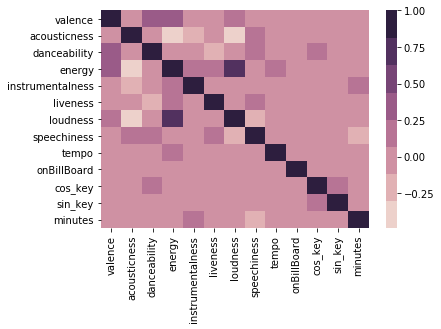

In [68]:
# calculate the correlation matrix

corr = df_audio.corr()

# plot the heatmap
sns.heatmap(corr, cmap=sns.cubehelix_palette(8),
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [6]:
df_audio.head()

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,onBillBoard,minutes,cos_key,sin_key
0,0.308,0.0777,0.573,0.543,0.00000,0.1990,-5.357,0.0398,143.916,0,3.722433,-0.500000,-0.866025
1,0.133,0.2480,0.662,0.496,0.00000,0.0769,-8.267,0.1090,81.951,1,2.993550,-0.866025,0.500000
2,0.587,0.1990,0.743,0.359,0.00611,0.1370,-10.401,0.0794,160.083,0,5.448883,0.866025,0.500000
3,0.321,0.2160,0.674,0.568,0.00000,0.0863,-7.678,0.0349,130.081,1,4.275550,-0.866025,-0.500000
4,0.860,0.0130,0.853,0.560,0.00000,0.0944,-4.961,0.0406,134.066,0,3.444883,0.866025,0.500000


Some of the key points to validate our intuition :  
    
+ *energy is equivalent to loudness (~1)* 
+ *energy is negatively correlated to acousticness (~-1)  *
+ *liveness is inverse to danceability   *
+ *valence(positivity) is positively related to energy and danceability  *

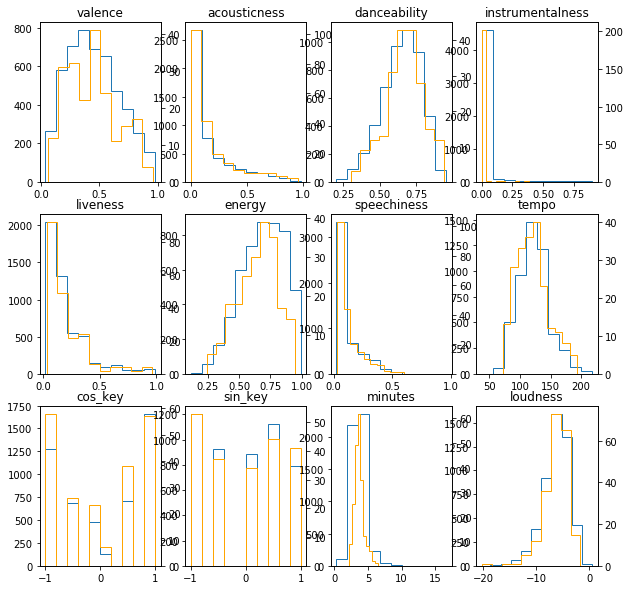

In [8]:
features=["valence","acousticness","danceability",'instrumentalness','liveness','energy','speechiness','tempo','cos_key','sin_key','minutes','loudness']

fig = plt.figure(figsize=(10,10))

for i in range(len(features)):
    ax1=fig.add_subplot(3,4,i+1)
    plt.hist(df_audio[df_audio.loc[:,"onBillBoard"]==0][features].iloc[:,i], label='label_0', histtype='step')
    
    ax2 = ax1.twinx()  
    plt.hist(df_audio[df_audio.loc[:,"onBillBoard"]==1][features].iloc[:,i], label='label_1', color='orange', histtype='step')
    
    ax2.yaxis.tick_right()
    ax1.set_title(df_audio[df_audio.loc[:,"onBillBoard"]==0][features].columns[i])

In [9]:
#log transforms
#acousticness, liveness, instrumentalness, speechiness, minutes
import math
def log_transform(feature):
    return feature.apply(lambda x : math.log1p(x))

for feature in (["acousticness",'liveness', 'instrumentalness', 'speechiness', 'minutes']):
    string="log_"+feature
    df_audio[string]=log_transform(df_audio[feature])

df_audio.head()

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,onBillBoard,minutes,cos_key,sin_key,log_acousticness,log_liveness,log_instrumentalness,log_speechiness,log_minutes
0,0.308,0.0777,0.573,0.543,0.00000,0.1990,-5.357,0.0398,143.916,0,3.722433,-0.500000,-0.866025,0.074829,0.181488,0.000000,0.039028,1.552324
1,0.133,0.2480,0.662,0.496,0.00000,0.0769,-8.267,0.1090,81.951,1,2.993550,-0.866025,0.500000,0.221542,0.074087,0.000000,0.103459,1.384681
2,0.587,0.1990,0.743,0.359,0.00611,0.1370,-10.401,0.0794,160.083,0,5.448883,0.866025,0.500000,0.181488,0.128393,0.006091,0.076405,1.863907
3,0.321,0.2160,0.674,0.568,0.00000,0.0863,-7.678,0.0349,130.081,1,4.275550,-0.866025,-0.500000,0.195567,0.082777,0.000000,0.034305,1.663083
4,0.860,0.0130,0.853,0.560,0.00000,0.0944,-4.961,0.0406,134.066,0,3.444883,0.866025,0.500000,0.012916,0.090206,0.000000,0.039797,1.491754


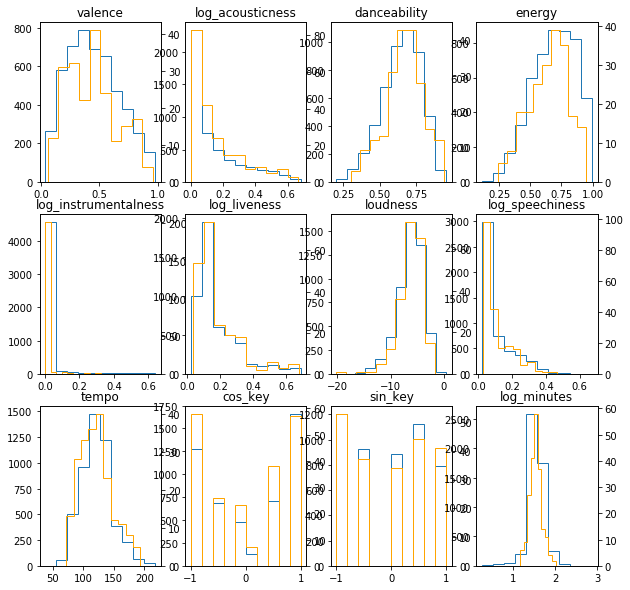

In [10]:
features=["valence","log_acousticness","danceability",'energy','log_instrumentalness','log_liveness','loudness','log_speechiness','tempo','cos_key','sin_key','log_minutes']

fig = plt.figure(figsize=(10,10))

for i in range(len(features)):
    ax1=fig.add_subplot(3,4,i+1)
    plt.hist(df_audio[df_audio.loc[:,"onBillBoard"]==0][features].iloc[:,i], label='label_0', histtype='step')
    
    ax2 = ax1.twinx()  
    plt.hist(df_audio[df_audio.loc[:,"onBillBoard"]==1][features].iloc[:,i], label='label_1', color='orange', histtype='step')
    
    ax2.yaxis.tick_right()
    ax1.set_title(df_audio[df_audio.loc[:,"onBillBoard"]==0][features].columns[i])

#### Understanding relationships using Decision tree Classifier

In [194]:
from sklearn import tree,metrics
import graphviz,pydotplus
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(max_depth=4,random_state=0)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(df_audio[features], df_audio[label], random_state=0)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [197]:
#clf = clf.fit(iris.data, iris.target)
dot=tree.export_graphviz(estimator,feature_names=features,out_file="mytree.dot",)

As decision trees are not sensitive to skewed distributions, features were fed as is (no transformations) to the classifier. The results show that loudness, instrumentalness, danceability, tempo and duration of the song play some role in deciding the popularity of the song.

<img src="https://image.ibb.co/cZefTy/decision_Tree.png">

### WordCloud 

In [8]:
from wordcloud import WordCloud, STOPWORDS
songs_df = pd.read_csv("finalDataset2.csv",encoding="latin")
nonBillBoardLyrics = ""
onBillBoardLyrics = ""
for i,row in songs_df.iterrows():
    if row["onBillBoard"] == 0:
        nonBillBoardLyrics+=" "+ " ".join(list(set(str(row["lyrics"]).split())))
    elif row["onBillBoard"] == 1:
        onBillBoardLyrics+=" "+" ".join(list(set(str(row["lyrics"]).split())))

# from wordcloud import WordCloud, STOPWORDS
stp = STOPWORDS
stpwrds = list(stp)
stpwrds.extend(["oh","yeah","love","got","know","ain't"])

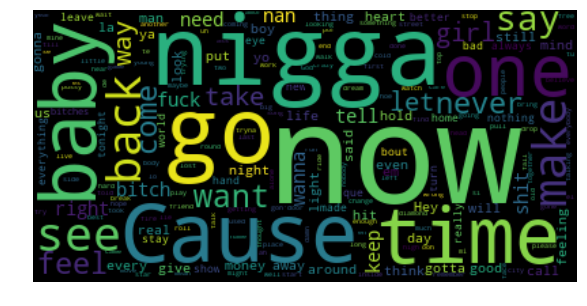

In [9]:
# Non BillBoard Songs WordCloud
wordcloud = WordCloud(collocations=False,stopwords=stpwrds).generate(nonBillBoardLyrics)
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

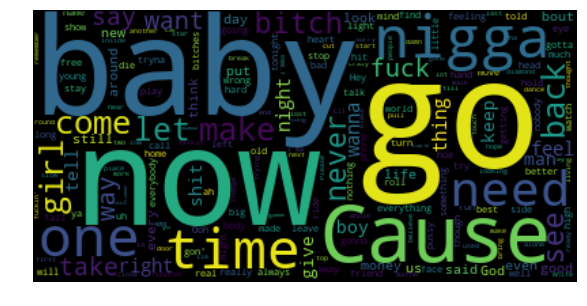

In [10]:
# BillBoard Songs WordCloud
wordcloud = WordCloud(collocations=False,stopwords=stpwrds).generate(onBillBoardLyrics)
plt.figure( figsize=(10,5) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("OnBillBoardLyricsWC.jpg")
plt.show()


<font color="blue">Through this word cloud wordcloud analysis, we can observe that on an average, songs with words that are racially charged are found in songs that eventually do not end up on the billboard. On the other hand, the word "baby" was very prominent in the songs that ended up on the billboard.   
If we think about it intuitively, we can say that songs that have an element of love and affection involved in them, tend to be a little more popular and relatable to people.  
This led us to dive deeper into extracting more features from the lyrics and we followed the process below to extract different features.</font>

## Data Processing <a id="Data Processing"></a>

<H3><a href="#Linguistic Features" style="color:Black">Linguistic Features</a></H3>
* <a href='#Emotional Features' style="color:blue">Emotional Features</a>  
* <a href='#Sentiment Score' style="color:blue">Sentiment Score</a>  
* <a href='#Psycholinguistic Features' style="color:blue">Psycholinguistic Features</a>  
* <a href='#Part of Speech' style="color:blue">Part of Speech</a>  
* <a href='#Interleaved Alliterations' style="color:blue">Interleaved Alliterations</a>  
* <a href='#Repetition using grams' style="color:blue">Repetition using n-grams</a>  

In [1]:
import pronouncing
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pprint

### Linguistic Features  <a id='Linguistic Features'></a>

#### Emotional Features <a id='Emotional Features'></a>

To look at the emotional content in the lyrics we have used an API named <a href=https://indico.io/docs#emotion>indico</a> which gives the score of fear, joy, sadness, suprise and anger ranging from 0 to 1.  
Note:- To use the following API you will need to enter a new API key **YOUR API KEY**

In [2]:
import indicoio
def analyze_emotions(text):
    """Take a text and calls the indico API to extract emotions related to that text(lyrics)

    Args:
        text (string): lyrics of a song

    Returns:
        dict : Dictionary containing 5 different emotions anger, fear, joy, sadness, suprise
    """
    try:
        indicoio.config.api_key = '<YOUR API KEY>'
        return indicoio.emotion(text)
    except:
        return {'anger': None,'fear': None,'joy': None,'sadness': None,'surprise': None}

<font color="green"><center>~Test Snippet~</center></font>
<center>
Oh, angel sent from up above  
You know you make my world light up  
When I was down, when I was hurt  
You came to lift me up  
Life is a drink and love's a drug  
Oh now I think I must be miles up  
When I was a river dried up  
You came to rain a flood</center>

In [3]:
test_snippet="""Oh, angel sent from up above
You know you make my world light up
When I was down, when I was hurt
You came to lift me up
Life is a drink and love's a drug
Oh now I think I must be miles up
When I was a river dried up
You came to rain a flood"""

In [4]:
pprint.pprint(analyze_emotions(test_snippet))

{'anger': 0.04350096732378006,
 'fear': 0.053040169179439545,
 'joy': 0.07789452373981476,
 'sadness': 0.4954047203063965,
 'surprise': 0.3301595449447632}


<font color="blue">As we observe that words like "hurt", "down","dried" accumulate to sad words in the song and thus the overall average words come out to be sad and words like "Oh" have been repeated multiple times and thus suprise is also a little prominent in the snippet.</font>

#### Sentiment Score <a id='Sentiment Score'></a>

To look at the overall sentiment in the lyrics text we have used <a href=https://cloud.google.com/natural-language>Google cloud natural language API</a> which gives the score of sentiment score ranging from -1 to 1. -1 tends to negative sentiment and 1 tends to highly positive sentiment score. 

Note:- To use the following API you will need to create an account on google cloud and instantiate a new project and import json containing the client and secret keys.

In [5]:
from google.cloud import language
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My Project-2fddb26847fa.json"

import googleapiclient.discovery

def analyze_sentiment(text, encoding='UTF32'):
    """Take a text string and calls the google cloud API to overall sentiment related to that text(lyrics)

    Args:
        text (string): lyrics of a song

    Returns:
        dict : Dictionary containing sentimentScore
    """
    try:
        body = {
            'document': {
                'type': 'PLAIN_TEXT',
                'content': text,
            },
            'encoding_type': encoding
        }

        service = googleapiclient.discovery.build('language', 'v1')

        request = service.documents().analyzeSentiment(body=body)
        response = request.execute()

        return {'sentimentScore':response['documentSentiment']['score']}
    except:
        return {'sentimentScore':None}


In [6]:
pprint.pprint(analyze_sentiment(test_snippet))

{'sentimentScore': 0.4}


<font color="blue">Though the overall sentiment score comes out to be positive because the sentiment of the combined sentences gives a positive sense.</font>

#### Psycholinguistic Features <a id='Psycholinguistic Features'></a>

The following code has been implemented using motivation from the following tutorial <a href=http://nbviewer.jupyter.org/url/datasciencecourse.org/tutorial_final/178/submission/PoetryAnalysisTutorial-final.ipynb>Poetic analysis</a>
we have used the <a href=http://websites.psychology.uwa.edu.au/school/MRCDatabase/uwa_mrc.htm>MRC psycholingstic dictionary</a> to extract 'familiarity','concreteness','imagery','meaningfulness' for each word in the sentence and then we have averaged them to calculat the average psycholinguistic features. 

Loading the MRC psycholingstic dictionary

Note:- To run this following code we have used this download link to get the MRC psycholingstic dictionary: <a href=https://github.com/samzhang111/mrc-psycholinguistics/blob/master/mrc2.dct>mrc2.dct</a>

In [7]:
mrc_dict = {}

for a in open('mrc2.dct.txt'):
    cols = a.split(' ', 1)
    b = list(cols[0])
    conc = int(b[28] + b[29] + b[30]) 
    imag = int(b[31] + b[32] + b[33]) 
    fam = int(b[25] + b[26] + b[27]) 
    meanc = int(b[34] + b[35] + b[36])
#     mean2 = int(b[37] + b[38] + b[39]) 
    try:
        word, phon, dphon, stress = cols[1][:-1].split(' ')[4].split('|')
        mrc_dict[word] = {'familiarity':fam, 'concreteness':conc, 'imagery':imag, 'meaningfulness':meanc}
    except:
        pass

print('Parsed the MRC psycholingstic dictionary of %d words'%len(mrc_dict))

Parsed the MRC psycholingstic dictionary of 31519 words


**Imagery** :- Imagery is a noun to describe the way things or ideas seem in your mind or in art or literature. Here we have used imagery for judgments of how easy it is to imagine a word.  
**Familiarity** :- Familarity is the measure of how familiar a word is, that is the commonality of the word.  
**Concreteness** :- Concreteness is an aspect of communication that means being specific, definite, and vivid rather than vague and general.    
**Meaningfulness** :-  Judgments of how related a word is to other words.

Range for all these features is 100 to 700.

In [8]:

def psycholinguistic_analysis(sentence, mrc_dict = mrc_dict):
    """Take a text string and calls MRC psycholingstic dictionary for each word in a sentence and averages their scores

    Args:
        text (string): lyrics of a song

    Returns:
        dict : Dictionary containing "average" familiarity,concreteness,imagery,meaningfulness
    """
    try:
        words=sentence.split()
        sentenceFeatures={'familiarity':[], 'concreteness':[], 'imagery':[], 'meaningfulness':[]}
        for word in np.unique(words):
            try: 
                x=mrc_dict[word.upper()]
                sentenceFeatures['familiarity'].append(x['familiarity'])
                sentenceFeatures['concreteness'].append(x['concreteness'])
                sentenceFeatures['imagery'].append(x['imagery'])
                sentenceFeatures['meaningfulness'].append(x['meaningfulness'])      
            except:
                pass

        psycholinguistic={}
        for key,value in sentenceFeatures.items():
            featureList=np.array(sentenceFeatures[key])
            psycholinguistic[key]=featureList[featureList.nonzero()].mean()

        return psycholinguistic
    
    except:
        return {'familiarity':None, 'concreteness':None, 'imagery':None, 'meaningfulness':None}

In [9]:
pprint.pprint(psycholinguistic_analysis(test_snippet))

{'concreteness': 351.62068965517244,
 'familiarity': 595.60000000000002,
 'imagery': 371.26666666666665,
 'meaningfulness': 391.11111111111109}


<font color="blue">We can see that familarity is quite high for the snippet as the words that are being used in context are commonly used words.</font>

#### Part of speech  <a id='Part of Speech'></a>

- We have used NLTK **pos_tag** to extract nouns verbs and adjectives part from the sentence.  
- We have used to analyze the difference between most common verbs, nouns and adjectives.

In [10]:
import nltk
def pos(text):   
    """Take a text string and extracts the part of speeches like nouns, verbs and adjectives

    Args:
        text (string): lyrics of a song

    Returns:
        dict : Dictionary containing number of nouns, number of verbs and number of adjectives
    """ 
    try:
        # function to test if something is a noun
        is_noun = lambda pos: pos[:2] in ['NNP','NN','NNS','NNPS']
        is_verb = lambda pos: pos[:2] in ['VB','VBD','VBG','VBN','VBP','VBZ']
        is_adjective= lambda pos:pos[:2] in ['JJ','JJR','JJS']
        # do the nlp stuff
        tokenized = nltk.word_tokenize(text)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        verbs = [word for (word, pos) in nltk.pos_tag(tokenized) if is_verb(pos)]
        adjectives = [word for (word, pos) in nltk.pos_tag(tokenized) if is_adjective(pos)]
        grammar={}
        grammar['#ofnouns']=len(set(nouns))
        grammar['#ofverbs']=len(set(verbs))
        grammar['#ofAdjectives']=len(set(adjectives))
        grammar['nouns']=list(set(nouns))
        grammar['verbs']=list(set(verbs))
        grammar['Adjectives']=list(set(adjectives))
        return grammar
    except:
        return {'#ofnouns':None,'#ofverbs':None,'#ofAdjectives':None,'nouns':None,'verbs':None,'Adjectives':None}
    pass

# tokenized = nltk.word_tokenize(text)
# nltk.pos_tag(tokenized)

In [11]:
pprint.pprint(pos(test_snippet))

{'#ofAdjectives': 1,
 '#ofnouns': 10,
 '#ofverbs': 12,
 'Adjectives': ['angel'],
 'nouns': ['drink',
           'sent',
           'miles',
           'Life',
           'river',
           'love',
           'world',
           'flood',
           'drug',
           'Oh'],
 'verbs': ['be',
           'make',
           'is',
           'came',
           'was',
           'rain',
           'lift',
           'think',
           'light',
           'dried',
           'know',
           'hurt']}


<font color="blue">As we can see that the NLTK library is quite accurate and thus gives out Nouns, Adjectives and verbs</font>

In [12]:
songs=pd.read_csv('TagsRemoved.csv',encoding='latin', index_col=False)

Adding them all together in our dataset.

In [13]:
emotions=[]
sentiment=[]
psycholinguistic=[]
partOfSpeech=[]

In [14]:
#adding lyrics based features
for index,row in songs.iterrows():
    emotions.append(analyze_emotions(row['lyrics']))
    sentiment.append(analyze_sentiment(row['lyrics']))
    psycholinguistic.append(psycholinguistic_analysis(row['lyrics']))
    partOfSpeech.append(pos(row['lyrics']))
    
#     print(index)


In [15]:
emotionsdf=pd.DataFrame(emotions)
sentimentdf=pd.DataFrame(sentiment)
psycholinguisticdf=pd.DataFrame(psycholinguistic)
partOfSpeechdf=pd.DataFrame(partOfSpeech)

new_df=pd.concat([songs, emotionsdf,sentimentdf,psycholinguisticdf,partOfSpeechdf], axis=1)

In [17]:
# new_df.to_csv('linguisticFeatures.csv')
songsWithLinguistic=pd.read_csv('linguisticFeatures.csv',encoding='latin', index_col=False)

In [18]:
nonBillboard=songsWithLinguistic.loc[songsWithLinguistic["onBillBoard"]==0,:]
Billboard=songsWithLinguistic.loc[songsWithLinguistic["onBillBoard"]==1,:]

print("""Average of #ofAdjectives for songs on Billboard {} and Average of #ofAdjectives for songs not on Billboard {}""".format(round(nonBillboard['#ofAdjectives'].mean(skipna=True),2),round(Billboard['#ofAdjectives'].mean(skipna=True),2)))

print("""Average of #ofnouns for songs on Billboard {} and Average of #ofnouns for songs not on Billboard {}""".format(round(nonBillboard['#ofnouns'].mean(skipna=True),2),round(Billboard['#ofnouns'].mean(skipna=True),2)))

print("""Average of #ofverbs for songs on Billboard {} and Average of #ofverbs for songs not on Billboard {}""".format(round(nonBillboard['#ofverbs'].mean(skipna=True),2),round(Billboard['#ofverbs'].mean(skipna=True),2)))


Average of #ofAdjectives for songs on Billboard 10.96 and Average of #ofAdjectives for songs not on Billboard 11.45
Average of #ofnouns for songs on Billboard 43.92 and Average of #ofnouns for songs not on Billboard 47.58
Average of #ofverbs for songs on Billboard 32.96 and Average of #ofverbs for songs not on Billboard 37.98


<font color="blue">We can observe that though there is not a lot of difference in Average of #ofnouns,#ofverbs and #ofAdjectives but for songs that appeared on the Billboard it is always less.</font>

In [19]:
from collections import Counter
import ast
def getKTopPOSwords(column,k):
    """Takes a column containing each row as a bag of words and the number of top k elements that you want to show

    Args:
        column (pd.Series): column you want a counter on

    Returns:
        list : list of most common k words in the column containing each row as a bag of words
        
    """ 
    allWords=[]
    
    for row in column.T:
        try:
            allWords.extend(ast.literal_eval(row))
        except:
            continue
    count=Counter(allWords)
    return count.most_common(k)


In [20]:
print('Top 10 nouns in Billboard songs:')
getKTopPOSwords(Billboard['nouns'],10)

Top 10 nouns in Billboard songs:


[('time', 74),
 ('way', 66),
 ('baby', 55),
 ('bitch', 53),
 ('night', 53),
 ('love', 50),
 ('girl', 46),
 ('shit', 42),
 ('money', 42),
 ('eyes', 37)]

In [21]:
print('Top 10 nouns in non Billboard songs:')
getKTopPOSwords(nonBillboard['nouns'],10)

Top 10 nouns in non Billboard songs:


[('time', 1266),
 ('way', 1011),
 ('love', 903),
 ('baby', 796),
 ('night', 710),
 ('life', 688),
 ('heart', 658),
 ('shit', 634),
 ('bitch', 607),
 ('money', 591)]

<font color="blue">Though we can see that the nouns are almost similar in non billboard and billboard songs but the ditribution is difference some nouns like "eyes", "girl" occur in billboard songs which are indicative that the songs on billboard could more related to love/affection.</font> 

In [22]:
print('Top 10 nouns in Billboard songs:')
getKTopPOSwords(Billboard['Adjectives'],10)

Top 10 nouns in Billboard songs:


[('good', 34),
 ('real', 34),
 ('new', 32),
 ('ta', 28),
 ('right', 28),
 ('free', 26),
 ('high', 26),
 ('na', 24),
 ('wrong', 24),
 ('more', 24)]

In [23]:
print('Top 10 nouns in non Billboard songs:')
getKTopPOSwords(nonBillboard['Adjectives'],10)

Top 10 nouns in non Billboard songs:


[('good', 630),
 ('real', 525),
 ('more', 494),
 ('na', 472),
 ('right', 438),
 ('little', 436),
 ('ta', 411),
 ('new', 407),
 ('bad', 406),
 ('nigga', 369)]

<font color="blue">Similarly, we observe that non billboard songs contain some racially biased adjectives whereas billboard songs don't.</font>

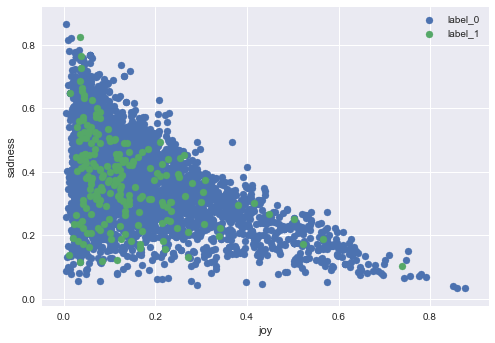

In [24]:
ig, ax = plt.subplots()
plt.scatter(nonBillboard["joy"], nonBillboard["sadness"], label='label_0')
plt.scatter(Billboard["joy"], Billboard["sadness"],  label='label_1')
plt.xlabel("joy")
plt.ylabel("sadness")
leg = ax.legend()

<font color="blue">Here we can observe that joy is quite high in non billboard songs and billboard songs tend to have moderate joy and sadness values</font>

#### Interleaved Alliterations <a id='Interleaved Alliterations'></a>
Now to get better understanding of figure of speeches in the songs we will be extracting features from the alliterations inovlved in a song.  
Following is an example that we have given for you to analyze and we have built an algorithm to extract interleaved aliteration patterns in a song.  

Algorithm:- We have used a pointer and text string find function and recursive calls to achieve all the alliteration patterns in a sentence.

Features:-
- Max alliteration for a syllable in a song (which alliteration per syllable has the highest number of words)
- Average alliteration (words per song participating in alliteration patterns) 
- Count of total number of alliteration patterns in a song.

We have choosen these three variables because we want to look at alliteration patterns as in if the length makes a difference or not. And also if the number of alliteration which shows that a song having multiple alliteration patterns, do they make a difference for a song's popularity. 

<img src="https://preview.ibb.co/e8qZmJ/alliterations.png">

In [29]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    try:
        text=text.lower()
        text=text.replace("'s","")
        text=text.replace("'","")
        for char in string.punctuation:
            text=text.replace(char," ")

        l=nltk.word_tokenize(text)
        lem=list()
        rem=list()
        for x in l:
            try:
                lem.append(lemmatizer.lemmatize(x))
            except Exception:
                rem.append(x)
                print("Ignore")
        return lem
    except:
        return ['']
    pass

In [25]:
# from collections import Counter
class aliteration():
    '''
    This class has been implemented to find out aliteration among text, we have synthesized this algorithm from scratch
    using the papers and simple definition of aliteration and phonetic sounds
    '''
    def __init__(self,text,skipRange):
        """init initialization of the class where we have initialized variables like 
        
        text(list that represents the first consonant of the phonetic sounds), 
        
        aliteration_dict(the final dictionary that represents all the pairs of aliterations), 
        
        text_string (the each word represented as high stress syllables extracted 
        using the first consonant from the phonetic representation of the word),
        
        skipRange (the continuity lookup range till which we consider alliteration in a sentence),
        
        max_aliterations_dict (dictionary contaning maximum number of aliteration per consonants)
        
        average_aliteration (average aliteration per song)
        
        num_of_aliterations_dict (dictionary contaning number of aliteration pairs per consonants)
        """ 
        self.text=text
        self.aliteration_dict={k:[1] for k in (set(self.text))}
        self.aliteration_dict
        self.text_string=''.join(text)
        self.skipRange=skipRange
        
        self.max_aliterations_dict={}
        self.num_of_aliterations_dict={}
        self.average_aliteration=0
    
    def calculate(self,pointer):
        """
        recursive function used to move the pointer for each consonant further
        
        args: pointer of the current position for each consonant 
        
        """
        new_text=self.text_string[pointer+1:]
        next_index=self.text_string.find(self.text[pointer],pointer+1)
        if next_index!=-1:
            if next_index-pointer<=self.skipRange:
                self.aliteration_dict[self.text[pointer]][-1]+=1
                self.calculate(next_index)
            else:
                self.aliteration_dict[self.text[pointer]].append(1)
                self.calculate(next_index)
                
    def run(self):
        """
        This function is used to train the aliteration patterns and populates the aliteration_dictionary
        """
        for key in self.aliteration_dict:
            intial_index=self.text_string.find(key)
            self.calculate(intial_index)
            
    def clean(self):
        """
        This function is used to remove any non aliteration
        """
        for k,v in self.aliteration_dict.items():
            while 1 in v: v.remove(1)
                
    def num_of_aliterations(self):
        """
        Creates a dictionary of all the consonants and their total number of aliterations that have occured in the text
        """
        for alphabet in map(chr, range(65, 91)):
            if alphabet not in self.aliteration_dict:
                self.num_of_aliterations_dict['count_al_'+alphabet]=0
            else:
                self.num_of_aliterations_dict['count_al_'+alphabet]=len(self.aliteration_dict[alphabet])
                
    def max_aliterations(self):
        """
        Creates a dictionary of all the consonants and their total number of aliterations that have occured in the text
        """
        for alphabet in map(chr, range(65, 91)):
            try:
                if alphabet not in self.aliteration_dict:
                    self.max_aliterations_dict['max_al_'+alphabet]=0
                else:
                    if len(self.aliteration_dict[alphabet])>0:
                        self.max_aliterations_dict['max_al_'+alphabet]=max(self.aliteration_dict[alphabet])
                    else:
                        self.max_aliterations_dict['max_al_'+alphabet]=0
            except:
                continue
    
    def calculate_average_aliteration(self):
        """
        calculates the average aliteration of the text that is the total number of words involved in aliteration patterns 
        divided by the total number of words.
        """
        for k,v in self.aliteration_dict.items():
            try:
                self.average_aliteration+=sum(v)
            except:
                continue
        try:
            self.average_aliteration=self.average_aliteration/len(self.text)
        except:
            self.average_aliteration=np.nan
                
    def empty_records(self):
        """
        clean empty records from the num of aliteration dictionary and max dictionary.
        """
        if sum(self.num_of_aliterations_dict.values())==0:
            self.num_of_aliterations_dict={'count_al_'+k:np.nan for k in list(map(chr, range(65, 91)))}
        if sum(self.max_aliterations_dict.values())==0:
            self.max_aliterations_dict={'max_al_'+k:np.nan for k in list(map(chr, range(65, 91)))}

In [30]:
from nltk.corpus import stopwords
def process_for_alliteration(text):
    """Takes lyrics of the songs and processes it get the first consonants of the phonetic sounds of the word
    for example "up" gives a phonetic sound using the CMU prnouncing library as "AH1 P" and "A" as the 
    stressed consonant so we use that in identifying the aliteration patterns.

    Args:
        text (string) : lyrics of a song

    Returns:
        list : list of first consonant related to each words phonetic sounds 
        
    """ 
    aliteration_list=[]
    tokenized_words=process(text)
#     print(tokenized_words)
    for word in tokenized_words:
        try:
            first_consonant=pronouncing.phones_for_word(word)[0][0]
            aliteration_list.append(first_consonant)
        except:
            continue
    return aliteration_list

<center><font color="red">~Test Snippet~</font></center>
<center>moans and screams merged  
with the sickening smell of  
woolen black clothes worn  
in summer weather and green  
leaves wilting over yellow flowers.</center>


In [31]:
test="""moans and screams merged 
with the sickening smell of woolen black clothes worn 
in summer weather and green leaves wilting over yellow flowers.
"""

In [32]:
processed_test=process_for_alliteration(test)
print(processed_test)

['M', 'A', 'S', 'M', 'W', 'D', 'S', 'S', 'A', 'W', 'B', 'K', 'W', 'I', 'S', 'W', 'A', 'G', 'L', 'W', 'O', 'Y', 'F']


In [33]:
# text=['U','A','M','S','M','S','S','W','B','K','W','S','W','G','L','W','O','Y','E']
# text=['A','A','S','S','Z','F','S','H','A','A','A']

skipRange=3
A=aliteration(processed_test,skipRange)
A.run()
A.clean()
A.aliteration_dict

{'A': [],
 'B': [],
 'D': [],
 'F': [],
 'G': [],
 'I': [],
 'K': [],
 'L': [],
 'M': [2],
 'O': [],
 'S': [2],
 'W': [3],
 'Y': []}

In [34]:
A.max_aliterations()
print(A.max_aliterations_dict)

{'max_al_A': 0, 'max_al_B': 0, 'max_al_C': 0, 'max_al_D': 0, 'max_al_E': 0, 'max_al_F': 0, 'max_al_G': 0, 'max_al_H': 0, 'max_al_I': 0, 'max_al_J': 0, 'max_al_K': 0, 'max_al_L': 0, 'max_al_M': 2, 'max_al_N': 0, 'max_al_O': 0, 'max_al_P': 0, 'max_al_Q': 0, 'max_al_R': 0, 'max_al_S': 2, 'max_al_T': 0, 'max_al_U': 0, 'max_al_V': 0, 'max_al_W': 3, 'max_al_X': 0, 'max_al_Y': 0, 'max_al_Z': 0}


In [35]:
A.num_of_aliterations()
print(A.num_of_aliterations_dict)

{'count_al_A': 0, 'count_al_B': 0, 'count_al_C': 0, 'count_al_D': 0, 'count_al_E': 0, 'count_al_F': 0, 'count_al_G': 0, 'count_al_H': 0, 'count_al_I': 0, 'count_al_J': 0, 'count_al_K': 0, 'count_al_L': 0, 'count_al_M': 1, 'count_al_N': 0, 'count_al_O': 0, 'count_al_P': 0, 'count_al_Q': 0, 'count_al_R': 0, 'count_al_S': 1, 'count_al_T': 0, 'count_al_U': 0, 'count_al_V': 0, 'count_al_W': 1, 'count_al_X': 0, 'count_al_Y': 0, 'count_al_Z': 0}


In [36]:
A.calculate_average_aliteration()
A.average_aliteration

0.30434782608695654

#### Repetition using n-grams <a id='Repetition using grams'></a>

We are using n-grams to look at repeating phrases and we look at the maximum repeated nth phrase in a song and we have looked at 2 to 100 grams, just to analyze if bigger repititions in a song makes a song appear on the billboard or smaller grams.

Later for our models we have bucketed grams in 5 buckets and added each 20 grams in one bucket.

In [37]:
from collections import Counter
def grams(text):
    """ takes in song lyrics and returns the length of 2 to 100 grams if present
    Inputs:
        text: lyrics of song
    Outputs:
        ngrams dictionary which contains the ngrams for 2 to 100 grams and their most common grams value count
    """
    ngrams={}
    for i in range(2,101):
        try:
            value=Counter(nltk.ngrams(process(text),i)).most_common(1)[0]
    #         print(value[1])
            value_list=Counter(nltk.ngrams(process(text),i)).most_common(1)[0][0]
            ngrams[str(i)+'_gram']=value[1]
    #         print(Counter(nltk.ngrams(process(text),i)).most_common(1))
        except:
            continue
    return ngrams


In [38]:
gram=[]
for index,row in songsWithLinguistic.iterrows():
    gram.append(grams(row['lyrics']))
        
#     print(index)

In [39]:
gramsdf=pd.DataFrame(gram)

df=pd.concat([songsWithLinguistic,gramsdf], axis=1)

In [40]:
# num_of_aliterations
finaldf.drop("#N/A",axis=1,inplace=True)
finaldf.to_csv('finalDataset.csv',encoding='latin')

In [41]:

num_of_aliterations=[]
average_aliteration=[]
max_aliteration=[]

skipRange=3

for index,row in finaldf.iterrows():
#     gram.append(grams(row['lyrics']))
    
    raw_text=row['lyrics']
    A=aliteration(process_for_alliteration(raw_text),skipRange)
    # print(A.aliteration_dict)
    A.run()
    A.clean()
    A.max_aliterations()
    A.calculate_average_aliteration()
    A.num_of_aliterations()
    
    A.num_of_aliterations_dict
    A.empty_records()
    
    num_of_aliterations.append(A.num_of_aliterations_dict)
    max_aliteration.append(A.max_aliterations_dict)
    average_aliteration.append({'average_aliteration':A.average_aliteration})
    
#     print(index)
    
num_of_aliterationsdf=pd.DataFrame(num_of_aliterations)
max_aliterationdf=pd.DataFrame(max_aliteration)
average_aliterationdf=pd.DataFrame(average_aliteration)

finaldf=pd.concat([finaldf,num_of_aliterationsdf,max_aliterationdf,average_aliterationdf], axis=1)

In [42]:
finaldf
finaldf.drop("#N/A",axis=1,inplace=True)
finaldf.to_csv('finalDataset2.csv',encoding='latin')

In [43]:
finaldf=pd.read_csv('finalDataset2.csv',encoding='latin',index_col=0)

In [44]:
print("Average alliteration per song in the whole dataset: "+str(round(finaldf['average_aliteration'].mean(),3)))

Average alliteration per song in the whole dataset: 0.387


In [45]:
nonBillboard=finaldf.loc[finaldf["onBillBoard"]==0,:]
Billboard=finaldf.loc[finaldf["onBillBoard"]==1,:]

In [46]:
count_nonBillboard_dictionary=list(map(lambda x:(x,nonBillboard['count_al_'+x].dropna().mean()),map(chr, range(65, 91))))
count_Billboard_dictionary=list(map(lambda x:(x,Billboard['count_al_'+x].dropna().mean()),map(chr, range(65, 91))))

The following outputs show the average alliterations starting from each letter in the alphabet for pop songs which did and did not feature on the BillBoard

In [47]:
pprint.pprint(count_nonBillboard_dictionary)

[('A', 10.93630229419703),
 ('B', 2.426990553306343),
 ('C', 0.06936572199730094),
 ('D', 5.5503373819163295),
 ('E', 0.5781376518218624),
 ('F', 1.106612685560054),
 ('G', 1.108502024291498),
 ('H', 1.4099865047233469),
 ('I', 3.069905533063428),
 ('J', 0.1241565452091768),
 ('K', 1.7878542510121458),
 ('L', 2.0099865047233467),
 ('M', 3.434278002699055),
 ('N', 1.9997300944669365),
 ('O', 0.4960863697705803),
 ('P', 0.5797570850202429),
 ('Q', 0.0),
 ('R', 0.5546558704453441),
 ('S', 3.299595141700405),
 ('T', 2.851821862348178),
 ('U', 0.09284750337381917),
 ('V', 0.03724696356275304),
 ('W', 3.4823211875843456),
 ('X', 0.0),
 ('Y', 2.720107962213225),
 ('Z', 0.006747638326585695)]


In [48]:
pprint.pprint(count_Billboard_dictionary)

[('A', 12.548076923076923),
 ('B', 3.1586538461538463),
 ('C', 0.02403846153846154),
 ('D', 6.826923076923077),
 ('E', 0.46153846153846156),
 ('F', 1.4230769230769231),
 ('G', 1.8461538461538463),
 ('H', 1.8269230769230769),
 ('I', 3.5240384615384617),
 ('J', 0.19230769230769232),
 ('K', 1.9951923076923077),
 ('L', 2.1201923076923075),
 ('M', 4.081730769230769),
 ('N', 2.4471153846153846),
 ('O', 0.7980769230769231),
 ('P', 0.9519230769230769),
 ('Q', 0.0),
 ('R', 0.8509615384615384),
 ('S', 3.4278846153846154),
 ('T', 3.269230769230769),
 ('U', 0.10096153846153846),
 ('V', 0.038461538461538464),
 ('W', 4.081730769230769),
 ('X', 0.0),
 ('Y', 3.076923076923077),
 ('Z', 0.019230769230769232)]


In [49]:
max_nonBillboard_dictionary=list(map(lambda x:(x,nonBillboard['max_al_'+x].dropna().mean()),map(chr, range(65, 91))))
max_Billboard_dictionary=list(map(lambda x:(x,Billboard['max_al_'+x].dropna().mean()),map(chr, range(65, 91))))

In [50]:
max_nonBillboard_dictionary

[('A', 4.5951417004048585),
 ('B', 1.81889338731444),
 ('C', 0.14385964912280702),
 ('D', 3.05748987854251),
 ('E', 0.555195681511471),
 ('F', 1.071255060728745),
 ('G', 1.0439946018893387),
 ('H', 1.3271255060728744),
 ('I', 2.108502024291498),
 ('J', 0.16383265856950066),
 ('K', 1.4893387314439945),
 ('L', 1.8383265856950068),
 ('M', 2.294736842105263),
 ('N', 1.7360323886639677),
 ('O', 0.6709851551956815),
 ('P', 0.6782726045883941),
 ('Q', 0.0),
 ('R', 0.6183535762483131),
 ('S', 2.239136302294197),
 ('T', 2.0663967611336034),
 ('U', 0.1349527665317139),
 ('V', 0.042105263157894736),
 ('W', 2.3492577597840754),
 ('X', 0.0),
 ('Y', 1.9430499325236168),
 ('Z', 0.014035087719298246)]

In [51]:
max_Billboard_dictionary

[('A', 4.966346153846154),
 ('B', 2.2259615384615383),
 ('C', 0.0625),
 ('D', 3.3413461538461537),
 ('E', 0.5576923076923077),
 ('F', 1.375),
 ('G', 1.5096153846153846),
 ('H', 1.7211538461538463),
 ('I', 2.2211538461538463),
 ('J', 0.27884615384615385),
 ('K', 1.4951923076923077),
 ('L', 1.8461538461538463),
 ('M', 2.514423076923077),
 ('N', 1.8942307692307692),
 ('O', 0.8461538461538461),
 ('P', 0.9375),
 ('Q', 0.0),
 ('R', 0.9567307692307693),
 ('S', 2.298076923076923),
 ('T', 2.1634615384615383),
 ('U', 0.12980769230769232),
 ('V', 0.04807692307692308),
 ('W', 2.8221153846153846),
 ('X', 0.0),
 ('Y', 2.2115384615384617),
 ('Z', 0.10096153846153846)]

<font color="blue">Looking at the average counts and max per consonant we can see that some consonants are more prominent than others for example A is quite a prominent consonant and is being used in alliteration patterns quite often.</font>

In [ ]:
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
import requests
from datetime import date, timedelta
import time, json, csv

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

import pronouncing
import nltk
import string
import pprint

As decision trees are not sensitive to skewed distributions, features were fed as is (no transformations) to the classifier. The results show that loudness, instrumentalness, danceability, tempo and duration of the song play some role in deciding the popularity of the song.

<img src="https://image.ibb.co/cZefTy/decision_Tree.png">

### Binning n-grams to 5 equally sized bins

In [25]:
gram_list=[]
for i in range(2,101,20):
    x=0
    for k in range(i,i+20):
        if k<101:
            x+=df[str(k)+'_gram'].fillna(0)
    gram_list.append(x.rename("gram"+str(i//20)))
    

bins=pd.concat(gram_list,axis=1)
transformed_audio=pd.concat([df[['#ofAdjectives',	'#ofnouns',	'#ofverbs',	'anger',	'concreteness',	'familiarity',	'fear',	'imagery','joy','meaningfulness','sadness',	'sentimentScore','surprise','count_al_A',	'count_al_B',	'count_al_C',	'count_al_D',	'count_al_E',	'count_al_F',	'count_al_G',	'count_al_H',	'count_al_I',	'count_al_J',	'count_al_K',	'count_al_L',	'count_al_M',	'count_al_N',	'count_al_O',	'count_al_P',	'count_al_Q',	'count_al_R',	'count_al_S',	'count_al_T',	'count_al_U',	'count_al_V',	'count_al_W',	'count_al_X',	'count_al_Y',	'count_al_Z',	'max_al_A',	'max_al_B',	'max_al_C',	'max_al_D',	'max_al_E',	'max_al_F',	'max_al_G',	'max_al_H',	'max_al_I',	'max_al_J',	'max_al_K',	'max_al_L',	'max_al_M',	'max_al_N',	'max_al_O',	'max_al_P',	'max_al_Q',	'max_al_R',	'max_al_S',	'max_al_T',	'max_al_U',	'max_al_V',	'max_al_W',	'max_al_X',	'max_al_Y',	'max_al_Z',	'average_aliteration',"onBillBoard"]],df_audio[features]], axis=1)
binned_df=pd.concat([transformed_audio,bins],axis=1)
df_all=binned_df
df_all[label].unique()

# final dataframe is df_all

array([0, 1], dtype=int64)

In [26]:
len(df_all.columns)

84

## Analysis <a id = "Analysis"></a>

## Combining all the features and training the classifier

In [27]:
column_features=["valence","log_acousticness","danceability",'energy','log_instrumentalness','log_liveness'
                 ,'loudness','log_speechiness','tempo','cos_key','sin_key','log_minutes','#ofAdjectives'
                 ,	'#ofnouns',	'#ofverbs','gram0','gram1','gram2','gram3','gram4',	'anger'
                 ,	'concreteness',	'familiarity',	'fear',	'imagery','joy','meaningfulness'
                 ,'sadness',	'sentimentScore','surprise','count_al_A',	'count_al_B'
                 ,	'count_al_C',	'count_al_D',	'count_al_E',	'count_al_F'
                 ,	'count_al_G',	'count_al_H',	'count_al_I',	'count_al_J'
                 ,	'count_al_K',	'count_al_L',	'count_al_M',	'count_al_N'
                 ,	'count_al_O',	'count_al_P',	'count_al_Q',	'count_al_R'
                 ,	'count_al_S',	'count_al_T',	'count_al_U',	'count_al_V'
                 ,	'count_al_W',	'count_al_X',	'count_al_Y',	'count_al_Z'
                 ,	'max_al_A',	'max_al_B',	'max_al_C',	'max_al_D',	'max_al_E'
                 ,	'max_al_F',	'max_al_G',	'max_al_H',	'max_al_I',	'max_al_J'
                 ,	'max_al_K',	'max_al_L',	'max_al_M',	'max_al_N',	'max_al_O'
                 ,	'max_al_P',	'max_al_Q',	'max_al_R',	'max_al_S',	'max_al_T'
                 ,	'max_al_U',	'max_al_V',	'max_al_W',	'max_al_X',	'max_al_Y'
                 ,	'max_al_Z',	'average_aliteration']
column_label="onBillBoard"

Given our positives are highly underrepresented, we will be using a technique called SMOTE(Synthetic Minority Over-sampling Technique) to oversample our positives. To learn about smote, you can refer to this [link](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)  

The technique used below is to synthetically generate the train test splits-
+ *First, the 10 folds are generated using stratified K-fold cross validation*
+ *Second, train split for each cycle is oversampled using SMOTE, but the test split is still the true representation of the data*
+ *Third, the model is trained on the train split (oversampled) and tested on the underrepresented untouched data*

Average Recall :  0.635


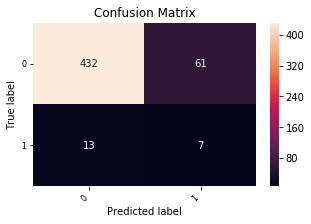

Average Recall :  0.8597619047619048


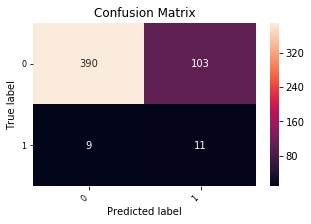

In [250]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score
kf=StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

def final_classifier(clf):
    errors=[]
    recall=[]
    X=df_all[column_features] #columns from above
    y=df_all[column_label]
    splits=kf.split(X,y) 
    sm = SMOTE(random_state=42)

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #missing value imputed using mean
        imputer = Imputer(missing_values="NaN") # all
        #normalized using norm-2
        normalize =  Normalizer() 

        X_train=imputer.fit_transform(X_train)
        X_test=imputer.transform(X_test)

        X_train=normalize.fit_transform(X_train)
        X_test=normalize.transform(X_test)

        X_res, y_res = sm.fit_sample(X_train, y_train)

        clf.fit(X_res,y_res)
        recall.append(recall_score(y_test,clf.predict(X_test)))

    print("Average Recall : ", np.array(recall).mean())
    print_confusion_matrix(confusion_matrix(y_test,clf.predict(X_test)),["0","1"])

final_classifier(LogisticRegression())
final_classifier(SVC(kernel="linear"))

<font color = "blue">We have defined our classification metrics as recall instead of accuracy (which would have had a baseline of 96%) because we are okay to live with FP i.e. categorizing some more to be probable of appearing on the 2016 Billboard charts but those did not show up because of one or more reasons.</font>

In [249]:
#source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (5,3), fontsize=8):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
  

### Absolute importance
We plotted the features in order of absolute importance

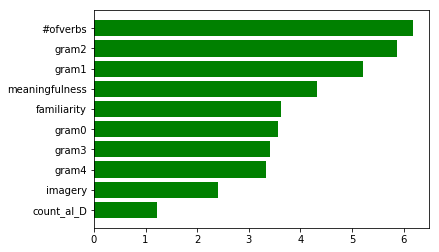

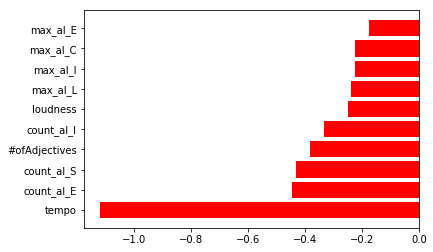

In [42]:
importances=clf.coef_

indices_top=np.argsort(clf.coef_)[0][-10:]
indices_bottom=np.argsort(clf.coef_)[0][:10]

plt.barh(range(10),importances[0][indices_top], color="green", align="center")
plt.yticks(range(10), df_all[column_features].columns[indices_top])
plt.show()

plt.barh(range(10),importances[0][indices_bottom], color="red", align="center")
plt.yticks(range(10), df_all[column_features].columns[indices_bottom])
plt.show()

Understanding the feature importances:
+ Number of verbs present in the song positively impact the popularity in the song.
+ The count of short length grams (buckets 0, 1, 2) contribute significantly in terms of making a song popular
+ Songs which have meaningful and familiar lyrics have a higher likelihood of gaining popularity
+ The tempo of a song negatively impacts the  

## Conclusion:
After the deep dive into lyric feature extraction in combination with the available music features of each song as provided by spotify, we achieved the following insights:
    
For a song to be popular:
1. It should consist of large number of short repetitve phrases. (Large number of short n-grams)
2. Songs with high danceability and moderate energy levels tend to be more popular.    

These insights can be both intuitively explained and interpreted as important features in a pop song. Taking for example, if a song has large number of repetitions, it becomes easier for listeners to memorize the song and that is something that can make it stick in the listeners' mind.

Danceability makes the have music features that allow them to be played in most places like clubs and parties, hence automatically promoting the song thus making it more likely to become popular.

In conclusion, we can say that given the data, we were able to achieve a good enough recall using a Logistic Regression for classification, while maintaining model interpretebility. Feature importances also helped us intuitively understand what kind of features can pop song artists target more to gain more popularity of their songs.

### Further Investigation
Through this project, we focussed on engineering features using lyrics and derived some really important insights that could play a vital role in making a pop song popular. Another important characteristic we could look into is the artists involved in the creation of the song. Through intuition, we feel that detailed artist information could also potentially add more value to our insights and help us achieve a better sense of song popularity.   

The data we had in this case was just the name of the artists involved in the song production, but artist data involving information like age, gender, nationality etc could help with more decisive classifications.  

Exploring lyric rhyming patterns could also be a great way to derive more insights from the existing data and could potentially add value to our analysis.


## References

+ Ivanov, L. (2016). Using Alliteration in Authorship Attribution of Historical Texts. Text, Speech, and Dialogue, pp.239-248.

+ Developers. Get Audio Features for a Track. Retrieved from spotify.com: https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

+ Hipolito, A. (2017, Nov 8). Spotify: Analyzing and Predicting Songs. Retrieved from https://medium.com: https://medium.com/mlreview/spotify-analyzing-and-predicting-songs-58827a0fa42b

+ Ivanov, L., & Petrovic, S. (2015, September 14). Using Lexical Stress in Authorship Attribution of Historical Texts. Retrieved from https://link.springer.com/chapter/10.1007/978-3-319-24033-6_12

+ Notebook on nbviewer. (n.d.). Retrieved from http://nbviewer.jupyter.org/url/datasciencecourse.org/tutorial_final/178/submission/PoetryAnalysisTutorial-final.ipynb